# Análise de dados dos jogos do Flamengo

In [1]:
# Carregando algumas bibliotecas importantes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns    

In [2]:
# Importando os arquivos
jogos = pd.read_csv('../data/matches_FLA2023.csv', parse_dates=['kick-off'])
gols = pd.read_csv('../data/goal_scorers.csv')

In [3]:
# Mostrando as 5 primeiras linhas do dataframe jogos
jogos.tail()

,id_match,home_team,away_team,home_score,away_score,tournament,kick-off,stadium
70,BR33,Flamengo,Fluminense,1,1,Campeonato Brasileiro - Round 33,2023-11-11 18:30:00,Maracanã-RJ
71,BR34,Flamengo,Bragantino,1,0,Campeonato Brasileiro - Round 34,2023-11-23 21:30:00,Maracanã-RJ
72,BR35,América Mineiro,Flamengo,0,3,Campeonato Brasileiro - Round 35,2023-11-26 18:30:00,Estádio Municipal Parque do Sabiá-MG
73,BR36,Flamengo,Atlético Mineiro,0,3,Campeonato Brasileiro - Round 36,2023-11-29 19:30:00,Maracanã-RJ
74,BR37,Flamengo,Cuiabá,2,1,Campeonato Brasileiro - Round 37,2023-12-03 16:00:00,Maracanã-RJ


In [4]:
# Mostrando as 5 primeiras linhas do dataframe gols
gols.tail()

,id_match,gols,assist
120,BR35,Everton Cebolinha,Ayrton Lucas
121,BR35,Pedro,Bruno Henrique
122,BR35,Everton Ribeiro,Everton Cebolinha
123,BR37,Luiz Araújo,Gerson
124,BR37,Pedro,Arrascaeta


**Criando a coluna torneio**

In [5]:
# Split o nome do torneio e a rodada
lista = [i.split(' -', 1)[0] for i in jogos["tournament"].tolist()]

# Transformando em uma nova coluna chamada torneio
jogos['torneio'] = np.array(lista)

**Criando a coluna casa/fora**

In [6]:
def obter_locale(row):
    if row['torneio'] == 'Supercopa do Brasil' or row['torneio'] == 'Club World Championship':
        return 'Neutro'
    elif row['home_team'] == 'Flamengo':
        return 'Casa'
    else:
        return 'Fora'

    
# Aplicar a função para criar a nova coluna
jogos['locale'] = jogos.apply(obter_locale, axis=1)

**Criando a coluna resultado**

In [7]:
# Função para obter resultado
def obter_resultado(row):
    if row['home_team'] == 'Flamengo':
        gols_marcados = row['home_score']
        gols_sofridos = row['away_score']
        
        if gols_marcados < gols_sofridos:
            return 'Derrota'
        elif gols_marcados > gols_sofridos:
            return 'Vitória'
        else:
            return 'Empate'
    if row['away_team'] == 'Flamengo':
        gols_marcados = row['away_score']
        gols_sofridos = row['home_score']

        if gols_marcados < gols_sofridos:
            return 'Derrota'
        elif gols_marcados > gols_sofridos:
            return 'Vitória'
        else:
            return 'Empate'

# Aplicar a função para criar a nova coluna
jogos['resultado'] = jogos.apply(obter_resultado, axis=1)

**Criando mais algumas colunas**

In [8]:
def gerar_estatisticas_gols(row):
    if row['home_team'] == 'Flamengo':
        gols_feitos_casa = row['home_score']
        gols_sofridos_casa = row['away_score']
        gols_feitos_fora = 0
        gols_sofridos_fora = 0
        marcou_gol = 'Sim' if row['home_score'] > 0 else 'Não'
        sofreu_gol = 'Sim' if row['away_score'] > 0 else 'Não'
    elif row['away_team'] == 'Flamengo':
        gols_feitos_casa = 0
        gols_sofridos_casa = 0
        gols_feitos_fora = row['away_score']
        gols_sofridos_fora = row['home_score']
        marcou_gol = 'Sim' if row['away_score'] > 0 else 'Não'
        sofreu_gol = 'Sim' if row['home_score'] > 0 else 'Não'
    else:
        gols_feitos_casa = 0
        gols_sofridos_casa = 0
        gols_feitos_fora = 0
        gols_sofridos_fora = 0
        marcou_gol = 'Não'
        sofreu_gol = 'Não'

    return pd.Series([gols_feitos_casa, gols_sofridos_casa, gols_feitos_fora, gols_sofridos_fora, marcou_gol, sofreu_gol])

jogos[['gols_casa', 'gols_sofridos_casa', 'gols_fora', 'gols_sofridos_fora', 'marcou_gol', 'sofreu_gol']] = jogos.apply(gerar_estatisticas_gols, axis=1)        

jogos['jogos_cumulativos'] = range(1, len(jogos) + 1)

## Algumas estatísticas

In [9]:
# Calculando os gols pró, sofridos e saldo de gols
gols_pro = jogos.gols_casa.sum() + jogos.gols_fora.sum()
gols_contra = jogos.gols_sofridos_casa.sum() + jogos.gols_sofridos_fora.sum()
saldo_gols = gols_pro - gols_contra

In [10]:
# Obtendo o número de vitórias, derrotas, empates e total de jogos
vitorias = jogos['resultado'].value_counts()[0]
derrotas = jogos['resultado'].value_counts()[1]
empates = jogos['resultado'].value_counts()[2]
total_jogos = vitorias + empates + derrotas

# Gols pro e sofridos por jogo
gols_per_jogo = round(gols_pro/total_jogos,2)
gols_sofrido_jogo = round(gols_contra/total_jogos,2)

# Calculando o aproveitamento
aproveitamento = round((3*vitorias + 1*empates + 0*derrotas)/(3*total_jogos)*100,2)
aproveitamento_pontos = (3*vitorias + 1*empates + 0*derrotas)

In [11]:
# Jogos em que marcou e sofreu gols
jogos.marcou_gol.value_counts()
jogos.sofreu_gol.value_counts()

jogos_marcou = jogos.marcou_gol.value_counts()[0]
jogos_não_marcou = jogos.marcou_gol.value_counts()[1]

jogos_sofreu = jogos.sofreu_gol.value_counts()[0]
jogos_não_sofreu = jogos.sofreu_gol.value_counts()[1]

In [12]:
stats = pd.DataFrame(jogos[['id_match', 'marcou_gol', 'sofreu_gol', 'kick-off', 'resultado', 'locale', 'jogos_cumulativos']])

stats['gols_marcados'] = jogos.gols_casa + jogos.gols_fora
stats['gols_sofridos'] = jogos.gols_sofridos_casa + jogos.gols_sofridos_fora

stats['gols_marcados_acumulados'] = stats['gols_marcados'].cumsum()
stats['gols_sofridos_acumulados'] = stats['gols_sofridos'].cumsum()
stats['diferença_gols_acumulados'] = stats['gols_marcados_acumulados'] - stats['gols_sofridos_acumulados']

In [13]:
print(
"""
Jogos: {0}
Vitórias: {1}
Empates: {2}
Derrotas: {3} 
Gols pro: {4}
Gols contra: {5}
Saldo de gols: +{6}
Gols/jogo: {7}
Gols sofridos/jogo: {8}
Jogos em que marcou: {9}
Jogos em que sofreu gol: {10} 
Aproveitamento: {11}%
Aproveitamento pontos: {12}/{13}
""".format(total_jogos,vitorias,empates,derrotas,gols_pro,gols_contra,saldo_gols,gols_per_jogo,
           gols_sofrido_jogo,jogos_marcou,jogos_sofreu,aproveitamento,aproveitamento_pontos, 3*total_jogos))


Jogos: 75
Vitórias: 41
Empates: 15
Derrotas: 19 
Gols pro: 125
Gols contra: 79
Saldo de gols: +46
Gols/jogo: 1.67
Gols sofridos/jogo: 1.05
Jogos em que marcou: 62
Jogos em que sofreu gol: 44 
Aproveitamento: 61.33%
Aproveitamento pontos: 138/225



## Criando tabelas com o número de gols e assistências

In [14]:
# Fazendo o merge dos dataframes jogos e gols
df = pd.merge(jogos, gols, on = 'id_match')
df.head()

,id_match,home_team,away_team,home_score,away_score,tournament,kick-off,stadium,torneio,locale,resultado,gols_casa,gols_sofridos_casa,gols_fora,gols_sofridos_fora,marcou_gol,sofreu_gol,jogos_cumulativos,gols,assist
0,CA1,Flamengo,Audax-RJ,1,0,Carioca - Taça Guanabara - Round 5,2023-01-12 21:30:00,Maracanã-RJ,Carioca,Casa,Vitória,1,0,0,0,Sim,Não,1,Matheus França,Thiaguinho
1,CA2,Flamengo,Portuguesa-RJ,4,1,Carioca - Taça Guanabara - Round 1,2023-01-15 18:00:00,Maracanã-RJ,Carioca,Casa,Vitória,4,1,0,0,Sim,Sim,2,Pedro,Ayrton Lucas
2,CA2,Flamengo,Portuguesa-RJ,4,1,Carioca - Taça Guanabara - Round 1,2023-01-15 18:00:00,Maracanã-RJ,Carioca,Casa,Vitória,4,1,0,0,Sim,Sim,2,Gabi,Pedro
3,CA2,Flamengo,Portuguesa-RJ,4,1,Carioca - Taça Guanabara - Round 1,2023-01-15 18:00:00,Maracanã-RJ,Carioca,Casa,Vitória,4,1,0,0,Sim,Sim,2,Fabrício Bruno,Pedro
4,CA2,Flamengo,Portuguesa-RJ,4,1,Carioca - Taça Guanabara - Round 1,2023-01-15 18:00:00,Maracanã-RJ,Carioca,Casa,Vitória,4,1,0,0,Sim,Sim,2,Thiago Maia,Matheuzinho


In [15]:
# Quantidade de gols por jogador
df_gols_counts = pd.DataFrame(gols.gols.value_counts())
df_gols_counts = df_gols_counts.reset_index()
df_gols_counts.columns = ['Jogador', 'Gols'] 

# Quantidade de assistência por jogador

df_assist_counts = pd.DataFrame(gols.assist.value_counts())
df_assist_counts = df_assist_counts.reset_index()
df_assist_counts.columns = ['Jogador', 'Assistências'] 

new_df = pd.concat([df_assist_counts, df_gols_counts], axis=1)
print(new_df.to_markdown(index=False))

| Jogador           |   Assistências | Jogador           |   Gols |
|:------------------|---------------:|:------------------|-------:|
| Arrascaeta        |             13 | Pedro             |     35 |
| Gerson            |             11 | Gabi              |     20 |
| Everton Cebolinha |             10 | Arrascaeta        |     11 |
| Ayrton Lucas      |              7 | Ayrton Lucas      |      7 |
| Everton Ribeiro   |              7 | Bruno Henrique    |      7 |
| Eric Pulgar       |              5 | Gerson            |      6 |
| Pedro             |              4 | Everton Cebolinha |      6 |
| Matheuzinho       |              4 | Léo Pereira       |      4 |
| Marinho           |              3 | Victor Hugo       |      3 |
| Gabi              |              3 | Everton Ribeiro   |      3 |
| Wesley            |              2 | Matheus França    |      3 |
| Mateusão          |              2 | Thiago Maia       |      3 |
| Bruno Henrique    |              2 | Fabrício 

In [16]:
# Unificando as tabelas gols e assistências
uni_df = pd.merge(df_gols_counts, df_assist_counts, on = 'Jogador', how ="left").fillna(0).head(15)

print(uni_df.to_markdown(index=False))

| Jogador           |   Gols |   Assistências |
|:------------------|-------:|---------------:|
| Pedro             |     35 |              4 |
| Gabi              |     20 |              3 |
| Arrascaeta        |     11 |             13 |
| Ayrton Lucas      |      7 |              7 |
| Bruno Henrique    |      7 |              2 |
| Gerson            |      6 |             11 |
| Everton Cebolinha |      6 |             10 |
| Léo Pereira       |      4 |              2 |
| Victor Hugo       |      3 |              2 |
| Everton Ribeiro   |      3 |              7 |
| Matheus França    |      3 |              0 |
| Thiago Maia       |      3 |              0 |
| Fabrício Bruno    |      3 |              0 |
| Luiz Araújo       |      3 |              1 |
| Matheus Gonçalves |      2 |              0 |


## Plotando Gráficos

**Número de Gols por mês**

In [17]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
             'August', 'September', 'October', 'November', 'December']

gols_feitos_total = stats.groupby(stats['kick-off'].dt.month_name())['gols_marcados'].sum().reindex(new_order, axis=0)
gols_sofridos_total = stats.groupby(stats['kick-off'].dt.month_name())['gols_sofridos'].sum().reindex(new_order, axis=0)
jogos_mes = stats.groupby(stats['kick-off'].dt.month_name())['jogos_cumulativos'].count().reindex(new_order, axis=0)

saldo = gols_feitos_total - gols_sofridos_total

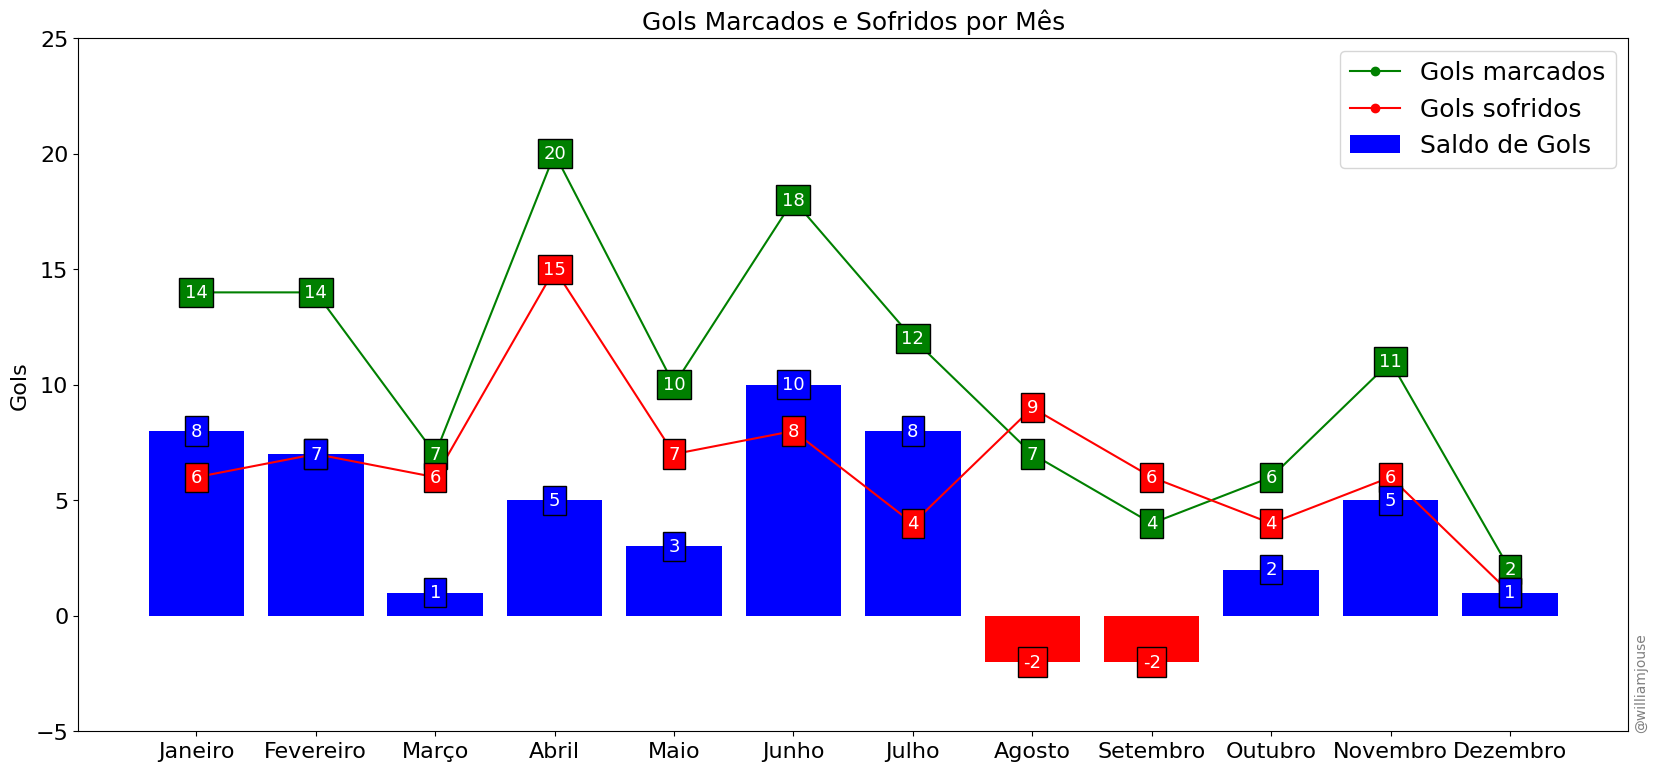

In [18]:
labels = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 
          'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

fig, ax = plt.subplots(figsize=(20, 9))

cores = ['red' if saldo < 0 else 'blue' for saldo in saldo]

plt.title('Gols Marcados e Sofridos por Mês', fontsize=18)

plt.bar(saldo.index, saldo, align='center', label = 'Saldo de Gols', color=cores)

plt.plot(gols_feitos_total.index, gols_feitos_total, marker = 'o', c = 'green', label = 'Gols marcados')
plt.plot(gols_sofridos_total.index, gols_sofridos_total, marker = 'o', c = 'red', label = 'Gols sofridos')


for i in range(len(gols_feitos_total.index.to_list())):
    plt.text(gols_feitos_total.index.to_list()[i], gols_feitos_total.to_list()[i], 
             str(gols_feitos_total.to_list()[i]), color='white', ha='center', va='center', fontsize='13', 
             bbox=dict(facecolor='green', edgecolor='black'))
    plt.text(gols_feitos_total.index.to_list()[i], gols_sofridos_total.to_list()[i], 
             str(gols_sofridos_total.to_list()[i]), color='white', ha='center', va='center', fontsize='13',
             bbox=dict(facecolor='red', edgecolor='black'))
    plt.text(saldo.index.to_list()[i], saldo.to_list()[i], str(saldo.to_list()[i]), color='white', fontsize='13', 
             ha='center', va='center', bbox=dict(facecolor=cores[i], edgecolor='black'))
    


plt.ylim(-5, 25)
plt.ylabel('Gols', fontsize=16)
plt.xticks(gols_feitos_total.index, labels, fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='upper right', fontsize=18)

plt.figtext(.91, 0.22, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)

plt.savefig('figures/figure.png', dpi = 300, bbox_inches='tight')
 
plt.show()

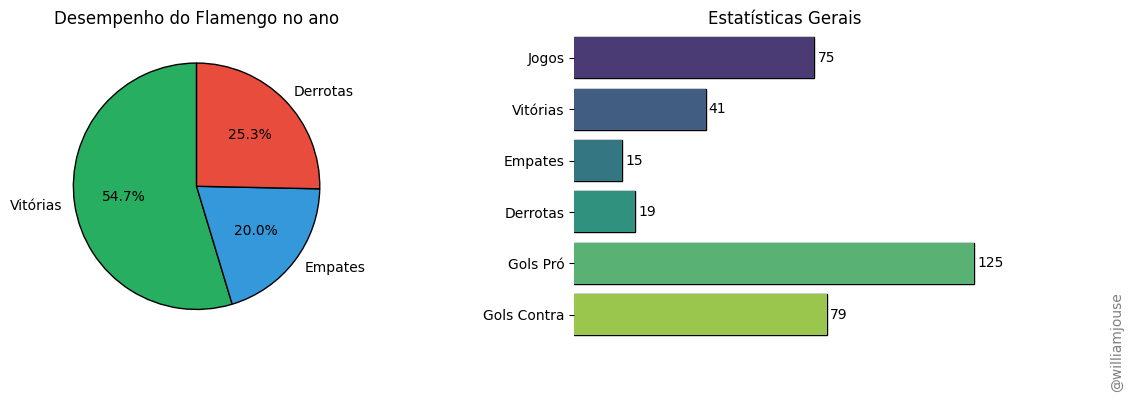

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

axs[0].pie([vitorias, empates, derrotas], labels=['Vitórias', 'Empates', 'Derrotas'], 
           autopct='%1.1f%%', startangle=90, colors=['#27AE60', '#3498DB', '#E74C3C'], wedgeprops={'edgecolor': 'black'})

axs[0].set_title('Desempenho do Flamengo no ano')

labels = ['Jogos', 'Vitórias', 'Empates', 'Derrotas', 'Gols Pró', 'Gols Contra']
values = [total_jogos, vitorias, empates, derrotas, gols_pro, gols_contra]
         
axs[1].barh(labels, values, color=['#27AE60', 'black', '#E74C3C', '#3498DB'], edgecolor='black')

for i, value in enumerate(values):
    axs[1].text(value + 1, i, str(value), va='center')
    
import seaborn as sns    
sns.barplot(x=values, y=labels, ax=axs[1], palette='viridis')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].set_xticks([])


axs[1].set_title('Estatísticas Gerais')


plt.subplots_adjust(wspace=0.4)

plt.figtext(1.0, 0.23, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)

plt.savefig('figures/figure2.png', dpi = 300, bbox_inches='tight')


plt.show()

In [20]:
jogos['Mês'] = jogos['kick-off'].dt.month_name()

agrupado = jogos.groupby(['Mês', 'resultado']).size().unstack().reindex(new_order, axis=0)


vic = agrupado['Vitória'].fillna(0).astype('Int64').to_list()
emp = agrupado['Empate'].fillna(0).astype('Int64').to_list()
der = agrupado['Derrota'].fillna(0).astype('Int64').to_list()
months = agrupado.index.to_list()

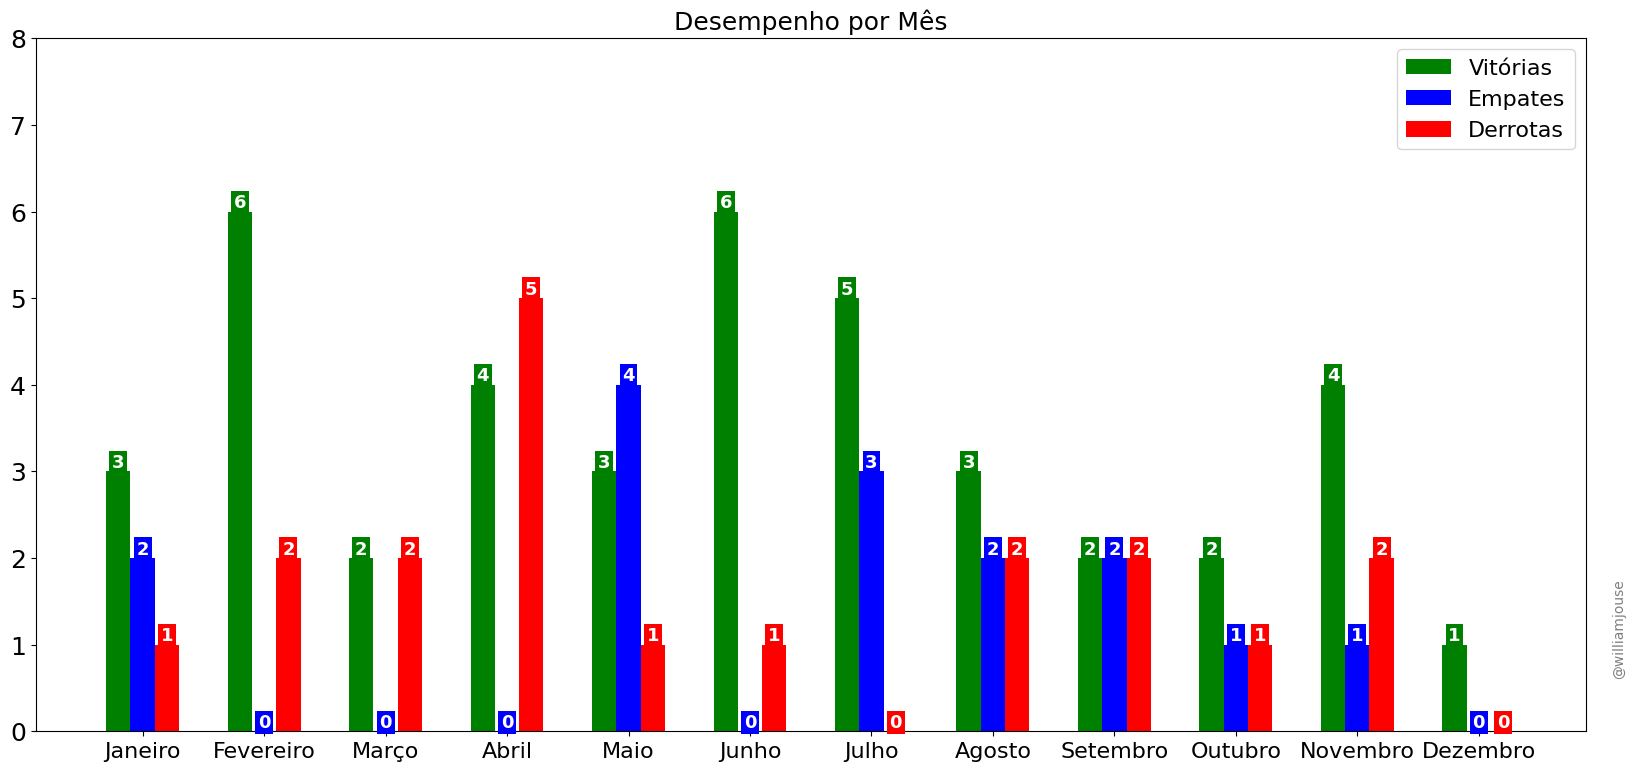

In [21]:
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
         'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

x = range(len(months))
largura_barra = 0.2

fig, ax = plt.subplots(figsize=(20, 9))

plt.title('Desempenho por Mês', fontsize=18)

plt.bar(x, vic, width=largura_barra, label='Vitórias', color='green')
plt.bar([i + largura_barra for i in x], emp, width=largura_barra, label='Empates', color='blue')
plt.bar([i + 2 * largura_barra for i in x], der, width=largura_barra, label='Derrotas', color='red')


for i, v in enumerate(vic):
    plt.text(i, v, str(v), ha='center', va='bottom', color='white', fontweight='bold', fontsize='13',
             bbox=dict(facecolor='green', edgecolor='none', pad=2))
for i, e in enumerate(emp):
    plt.text(i + largura_barra, e, str(e), ha='center', va='bottom', color='white', fontweight='bold', fontsize='13',
             bbox=dict(facecolor='blue', edgecolor='none', pad=2))
for i, d in enumerate(der):
    plt.text(i + 2 * largura_barra, d, str(d), ha='center', va='bottom', color='white', fontweight='bold', fontsize='13',
             bbox=dict(facecolor='red', edgecolor='none', pad=2))

plt.xticks([i + largura_barra for i in x], meses, fontsize=16)

plt.yticks(fontsize=18)
plt.ylim(0, max(vic + emp + der) + 2)

# Adicionando uma legenda
green_patch = mpatches.Patch(color='green', label='Vitórias')
blue_patch = mpatches.Patch(color='blue', label='Empates')
red_patch = mpatches.Patch(color='red', label='Derrotas')
plt.legend(handles=[green_patch, blue_patch, red_patch], fontsize=16)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)

plt.figtext(.92, 0.28, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)

plt.legend(loc='upper right', fontsize=16)

plt.savefig('figures/figure3.png', dpi = 300, bbox_inches='tight')

plt.show()

In [22]:
stats_copy = stats.copy()

MJ_games = stats_copy.iloc[[0, 4, 21, 22, 62, 63],:]

stats_copy.drop(MJ_games.index, inplace=True)

VP_time = stats_copy.loc[(stats_copy['kick-off'] >= pd.to_datetime('2023-01-12')) & (stats_copy['kick-off']
                                       <= pd.to_datetime('2023-04-13'))]

Sampaoli_time = stats_copy.loc[(stats_copy['kick-off'] >= pd.to_datetime('2023-04-14')) & (stats_copy['kick-off']
                                       <= pd.to_datetime('2023-09-29'))]

Tite_time = stats_copy.loc[(stats_copy['kick-off'] >= pd.to_datetime('2023-09-29'))] 



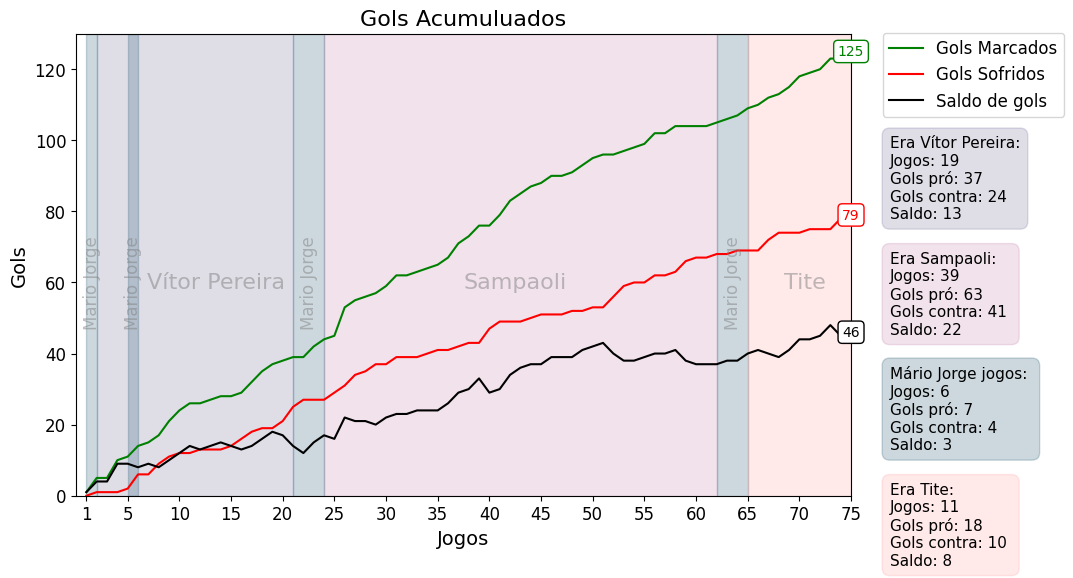

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.title('Gols Acumuluados', fontsize=16)

plt.plot(stats['jogos_cumulativos'], stats.gols_marcados.cumsum(), label='Gols Marcados', color='green')
plt.plot(stats['jogos_cumulativos'], stats.gols_sofridos.cumsum(), label='Gols Sofridos', color='red')
plt.plot(stats['jogos_cumulativos'], stats.gols_marcados.cumsum() - stats.gols_sofridos.cumsum(), label='Saldo de gols', color='black')

plt.axvspan(min(VP_time['jogos_cumulativos']), max(VP_time['jogos_cumulativos']),
           facecolor='#5f5a8b', edgecolor='#5f5a8b', alpha=.2)

plt.axvspan(min(Sampaoli_time['jogos_cumulativos']), max(Sampaoli_time['jogos_cumulativos']),
           facecolor='#b96f9d', edgecolor='#b96f9d', alpha=.2)

for i in [0, 1]:#range(len(MJ_games.jogos_cumulativos)):
    plt.axvspan(MJ_games['jogos_cumulativos'].to_list()[i], MJ_games['jogos_cumulativos'].to_list()[i] + 1,
               facecolor='#003f5c', edgecolor='#003f5c', alpha=.2)
    

for i in [2, 4]:
    plt.axvspan(MJ_games['jogos_cumulativos'].to_list()[i] - 1, MJ_games['jogos_cumulativos'].to_list()[i] + 2, 
                facecolor='#003f5c', edgecolor='#003f5c', alpha=.2)
    
    
plt.axvspan(min(Tite_time['jogos_cumulativos']), max(Tite_time['jogos_cumulativos']),
           facecolor='#ff9191', edgecolor='#ff9191', alpha=.2)



plt.ylim(0, 130)
plt.xlim(0, 75)

plt.ylabel('Gols', fontsize=14)
plt.yticks(fontsize=12)

plt.xlabel('Jogos', fontsize=14)
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75], fontsize=12)

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=14)

plt.text(13.5,60, 'Vítor Pereira', fontsize=16, color='gray', alpha=0.5,
        ha='center', va='center')

plt.text(42.5, 60, 'Sampaoli', fontsize=16, color='gray', alpha=0.5,
        ha='center', va='center')

for i, j in [[1.55, 60], [5.55, 60], [22.55, 60], [63.55, 60]]:
    plt.text(i, j, 'Mario Jorge', fontsize=12, color='gray', alpha=0.5,
        ha='center', va='center', rotation=90)
    
plt.text(70.55,60, 'Tite', fontsize=16, color='gray', alpha=0.5,
        ha='center', va='center')    


box_offset = 5  # Adjust this value to control the vertical offset of the boxes
plt.text(len(stats.gols_marcados.cumsum()), stats.gols_marcados.cumsum().iloc[-1], f'{stats.gols_marcados.cumsum().iloc[-1]}',
         ha='center', va='center', color='green', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'),
         fontsize=10)

plt.text(len(stats.gols_sofridos.cumsum()), stats.gols_sofridos.cumsum().iloc[-1], f'{stats.gols_sofridos.cumsum().iloc[-1]}',
         ha='center', va='center', color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'),
         fontsize=10)

plt.text(len(stats.gols_marcados.cumsum()), (stats.gols_marcados.cumsum() - stats.gols_sofridos.cumsum()).iloc[-1],
         f'{(stats.gols_marcados.cumsum() - stats.gols_sofridos.cumsum()).iloc[-1]}',
         ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
         fontsize=10)


MJ_stats = '''Mário Jorge jogos: 
Jogos: {0}
Gols pró: {1} 
Gols contra: {2} 
Saldo: {3}'''.format(MJ_games.shape[0],
                        MJ_games['gols_marcados'].sum(), 
                        MJ_games['gols_sofridos'].sum(), 
                        MJ_games['gols_marcados'].sum() - MJ_games['gols_sofridos'].sum())

VP_stats = '''Era Vítor Pereira:
Jogos: {0}
Gols pró: {1} 
Gols contra: {2} 
Saldo: {3}'''.format(VP_time.shape[0],
                        VP_time['gols_marcados'].sum(), 
                        VP_time['gols_sofridos'].sum(), 
                        VP_time['gols_marcados'].sum() - VP_time['gols_sofridos'].sum())


Sampaoli_stats = '''Era Sampaoli: 
Jogos: {0}
Gols pró: {1} 
Gols contra: {2} 
Saldo: {3}'''.format(Sampaoli_time.shape[0],
                        Sampaoli_time['gols_marcados'].sum(), 
                        Sampaoli_time['gols_sofridos'].sum(), 
                        Sampaoli_time['gols_marcados'].sum() - Sampaoli_time['gols_sofridos'].sum())

Tite_stats = '''Era Tite: 
Jogos: {0}
Gols pró: {1} 
Gols contra: {2} 
Saldo: {3}'''.format(Tite_time.shape[0],
                        Tite_time['gols_marcados'].sum(), 
                        Tite_time['gols_sofridos'].sum(), 
                        Tite_time['gols_marcados'].sum() - Tite_time['gols_sofridos'].sum())


plt.text(1.05, 0.6, VP_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='#5f5a8b', edgecolor='#5f5a8b', alpha=.2, boxstyle='round, pad=0.5'))

plt.text(1.05, 0.35, Sampaoli_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='#b96f9d', edgecolor='#b96f9d', alpha=.2, boxstyle='round, pad=0.5'))

plt.text(1.05, 0.10, MJ_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='#003f5c', edgecolor='#003f5c', alpha=.2, boxstyle='round, pad=0.5'))

plt.text(1.05, -0.15, Tite_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='#ff9191', edgecolor='#ff9191', alpha=.2, boxstyle='round, pad=0.5'))

plt.legend(bbox_to_anchor=(1.03, 1.02), loc='upper left', fontsize=12)

#plt.figtext(.92, 0.28, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)


plt.savefig('figures/figure4.png', dpi = 300, bbox_inches='tight')

plt.show()

In [24]:
VP_jogos = VP_time.copy()

VP_jogos = VP_jogos.reset_index(drop=True)

VP_jogos['jogos_cumulativos'] = range(1, len(VP_jogos) + 1)

VP_jogos['gols_marcados_acumulados'] = VP_jogos['gols_marcados'].cumsum()
VP_jogos['gols_sofridos_acumulados'] = VP_jogos['gols_sofridos'].cumsum()
VP_jogos['diferença_gols_acumulados'] = VP_jogos['gols_marcados_acumulados'] - VP_jogos['gols_sofridos_acumulados']

Sampaoli_jogos = Sampaoli_time.copy()

Sampaoli_jogos = Sampaoli_jogos.reset_index(drop=True)

Sampaoli_jogos['jogos_cumulativos'] = range(1, len(Sampaoli_jogos) + 1)
Sampaoli_jogos['gols_marcados_acumulados'] = Sampaoli_jogos['gols_marcados'].cumsum()
Sampaoli_jogos['gols_sofridos_acumulados'] = Sampaoli_jogos['gols_sofridos'].cumsum()
Sampaoli_jogos['diferença_gols_acumulados'] = Sampaoli_jogos['gols_marcados_acumulados'] - Sampaoli_jogos['gols_sofridos_acumulados']


Tite_jogos = Tite_time.copy()

Tite_jogos = Tite_jogos.reset_index(drop=True)

Tite_jogos['jogos_cumulativos'] = range(1, len(Tite_jogos) + 1)

Tite_jogos['gols_marcados_acumulados'] = Tite_jogos['gols_marcados'].cumsum()
Tite_jogos['gols_sofridos_acumulados'] = Tite_jogos['gols_sofridos'].cumsum()
Tite_jogos['diferença_gols_acumulados'] = Tite_jogos['gols_marcados_acumulados'] - Tite_jogos['gols_sofridos_acumulados']

In [25]:
def obter_aproveitamento(row):
    if row == 'Vitória':
        return 3
    elif row == 'Empate':
        return 1
    else:
        return 0
       
Sampaoli_jogos['pontos'] = Sampaoli_jogos['resultado'].apply(obter_aproveitamento)

Sampaoli_jogos['aproveitamento_acumulado'] = Sampaoli_jogos['pontos'].cumsum()

Tite_jogos['pontos'] = Tite_jogos['resultado'].apply(obter_aproveitamento)

Tite_jogos['aproveitamento_acumulado'] = Tite_jogos['pontos'].cumsum()

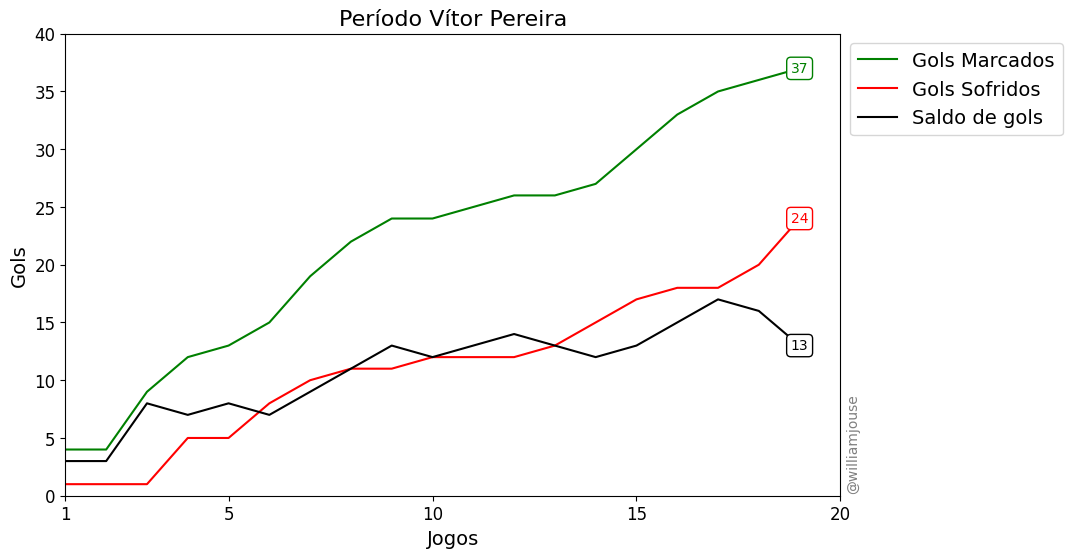

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.title('Período Vítor Pereira', fontsize=16)


plt.plot(VP_jogos['jogos_cumulativos'], VP_jogos.gols_marcados.cumsum(), label='Gols Marcados', color='green')
plt.plot(VP_jogos['jogos_cumulativos'], VP_jogos.gols_sofridos.cumsum(), label='Gols Sofridos', color='red')
plt.plot(VP_jogos['jogos_cumulativos'], VP_jogos.gols_marcados.cumsum() - VP_jogos.gols_sofridos.cumsum(), label='Saldo de gols', color='black')

plt.ylim(0, 40)
plt.xlim(1, 20)

plt.ylabel('Gols', fontsize=14)
plt.yticks(fontsize=12)

plt.xlabel('Jogos', fontsize=14)
plt.xticks([1, 5, 10, 15, 20], fontsize=12)

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=14)

plt.text(len(VP_jogos.gols_marcados.cumsum()), VP_jogos.gols_marcados.cumsum().iloc[-1], f'{VP_jogos.gols_marcados.cumsum().iloc[-1]}',
         ha='center', va='center', color='green', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'),
         fontsize=10)

plt.text(len(VP_jogos.gols_sofridos.cumsum()), VP_jogos.gols_sofridos.cumsum().iloc[-1], f'{VP_jogos.gols_sofridos.cumsum().iloc[-1]}',
         ha='center', va='center', color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'),
         fontsize=10)


plt.text(len(VP_jogos.gols_marcados.cumsum()), (VP_jogos.gols_marcados.cumsum() - VP_jogos.gols_sofridos.cumsum()).iloc[-1],
         f'{(VP_jogos.gols_marcados.cumsum() - VP_jogos.gols_sofridos.cumsum()).iloc[-1]}',
         ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
         fontsize=10)


plt.figtext(.92, 0.28, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)

plt.savefig('figures/figure5.png', dpi = 300, bbox_inches='tight')


#plt.show()

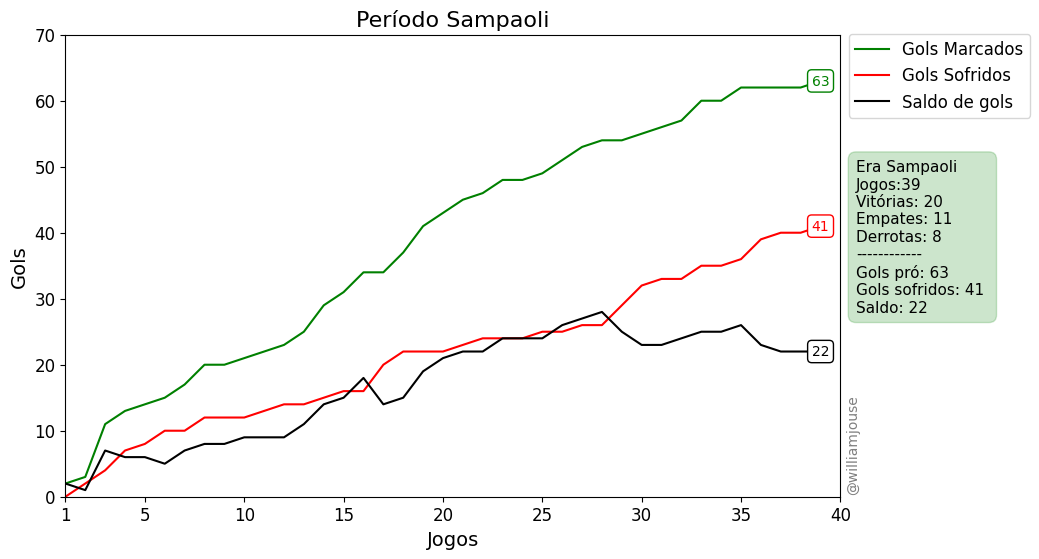

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.title('Período Sampaoli', fontsize=16)

plt.plot(Sampaoli_jogos['jogos_cumulativos'], Sampaoli_jogos.gols_marcados.cumsum(), label='Gols Marcados', color='green')
plt.plot(Sampaoli_jogos['jogos_cumulativos'], Sampaoli_jogos.gols_sofridos.cumsum(), label='Gols Sofridos', color='red')
plt.plot(Sampaoli_jogos['jogos_cumulativos'], Sampaoli_jogos.gols_marcados.cumsum() - Sampaoli_jogos.gols_sofridos.cumsum(), label='Saldo de gols', color='black')

plt.ylim(0, 70)
plt.xlim(1, 30)

plt.ylabel('Gols', fontsize=14)
plt.yticks(fontsize=12)

plt.xlabel('Jogos', fontsize=14)
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40], fontsize=12)

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=14)


plt.text(len(Sampaoli_jogos.gols_marcados.cumsum()), Sampaoli_jogos.gols_marcados.cumsum().iloc[-1], f'{Sampaoli_jogos.gols_marcados.cumsum().iloc[-1]}',
         ha='center', va='center', color='green', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'),
         fontsize=10)

plt.text(len(Sampaoli_jogos.gols_sofridos.cumsum()), Sampaoli_jogos.gols_sofridos.cumsum().iloc[-1], f'{Sampaoli_jogos.gols_sofridos.cumsum().iloc[-1]}',
         ha='center', va='center', color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'),
         fontsize=10)


plt.text(len(Sampaoli_jogos.gols_marcados.cumsum()), (Sampaoli_jogos.gols_marcados.cumsum() - Sampaoli_jogos.gols_sofridos.cumsum()).iloc[-1],
         f'{(Sampaoli_jogos.gols_marcados.cumsum() - Sampaoli_jogos.gols_sofridos.cumsum()).iloc[-1]}',
         ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
         fontsize=10)

Sampaoli_stats = '''Era Sampaoli
Jogos:{0}
Vitórias: {1} 
Empates: {2} 
Derrotas: {3} 
------------
Gols pró: {4}
Gols sofridos: {5} 
Saldo: {6} '''.format(Sampaoli_jogos.shape[0],
                        Sampaoli_jogos['resultado'].value_counts()[0], 
                        Sampaoli_jogos['resultado'].value_counts()[1], 
                        Sampaoli_jogos['resultado'].value_counts()[2],
                        Sampaoli_jogos['gols_marcados'].sum(), 
                        Sampaoli_jogos['gols_sofridos'].sum(), 
                        Sampaoli_jogos['gols_marcados'].sum() - Sampaoli_time['gols_sofridos'].sum())


plt.text(1.02, 0.40, Sampaoli_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='g', edgecolor='g', alpha=.2, boxstyle='round, pad=0.5'))

plt.figtext(.92, 0.28, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)

plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=12)


plt.savefig('figures/figure6.jpg', dpi = 300, bbox_inches='tight')


plt.show()

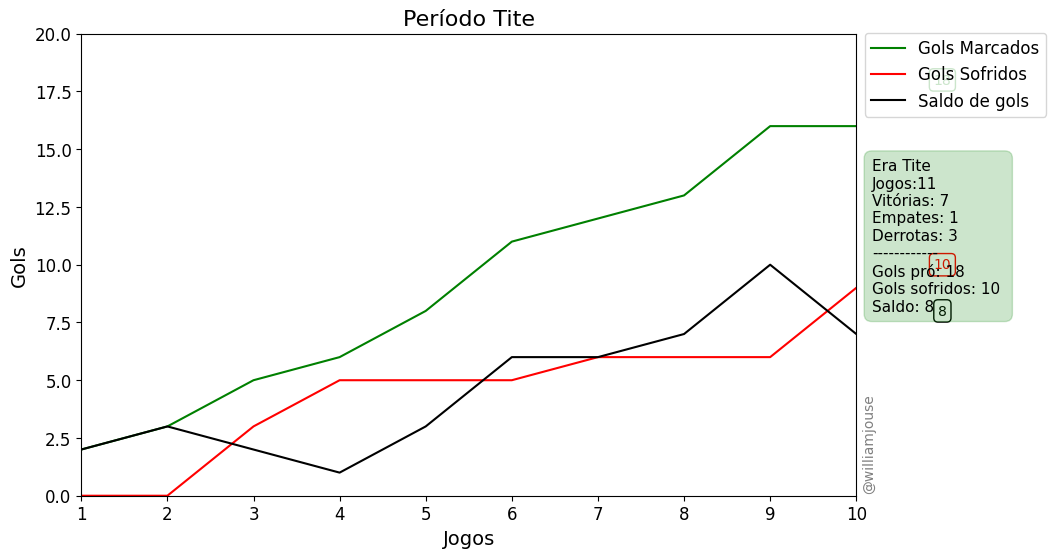

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.title('Período Tite', fontsize=16)

plt.plot(Tite_jogos['jogos_cumulativos'], Tite_jogos.gols_marcados.cumsum(), label='Gols Marcados', color='green')
plt.plot(Tite_jogos['jogos_cumulativos'], Tite_jogos.gols_sofridos.cumsum(), label='Gols Sofridos', color='red')
plt.plot(Tite_jogos['jogos_cumulativos'], Tite_jogos.gols_marcados.cumsum() - Tite_jogos.gols_sofridos.cumsum(), label='Saldo de gols', color='black')

plt.ylim(0, 20)
plt.xlim(1, 10)

plt.ylabel('Gols', fontsize=14)
plt.yticks(fontsize=12)

plt.xlabel('Jogos', fontsize=14)
plt.xticks(np.linspace(1, 10, 10), fontsize=12)

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=14)


plt.text(len(Tite_jogos.gols_marcados.cumsum()), Tite_jogos.gols_marcados.cumsum().iloc[-1], f'{Tite_jogos.gols_marcados.cumsum().iloc[-1]}',
         ha='center', va='center', color='green', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'),
         fontsize=10)

plt.text(len(Tite_jogos.gols_sofridos.cumsum()), Tite_jogos.gols_sofridos.cumsum().iloc[-1], f'{Tite_jogos.gols_sofridos.cumsum().iloc[-1]}',
         ha='center', va='center', color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'),
         fontsize=10)


plt.text(len(Tite_jogos.gols_marcados.cumsum()), (Tite_jogos.gols_marcados.cumsum() - Tite_jogos.gols_sofridos.cumsum()).iloc[-1],
         f'{(Tite_jogos.gols_marcados.cumsum() - Tite_jogos.gols_sofridos.cumsum()).iloc[-1]}',
         ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
         fontsize=10)

Tite_stats = '''Era Tite
Jogos:{0}
Vitórias: {1} 
Empates: {2} 
Derrotas: {3} 
------------
Gols pró: {4}
Gols sofridos: {5} 
Saldo: {6} '''.format(Tite_jogos.shape[0],
                        Tite_jogos['resultado'].value_counts()[0], 
                        Tite_jogos['resultado'].value_counts()[2], 
                        Tite_jogos['resultado'].value_counts()[1],
                        Tite_jogos['gols_marcados'].sum(), 
                        Tite_jogos['gols_sofridos'].sum(), 
                        Tite_jogos['gols_marcados'].sum() - Tite_time['gols_sofridos'].sum())


plt.text(1.02, 0.40, Tite_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='g', edgecolor='g', alpha=.2, boxstyle='round, pad=0.5'))

plt.figtext(.92, 0.28, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)

plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=12)


plt.savefig('figures/figure7.jpg', dpi = 300, bbox_inches='tight')


plt.show()

In [29]:
msk = stats.loc[stats.gols_sofridos >= 3]['id_match']
pd.merge(jogos, msk, on = 'id_match' )

,id_match,home_team,away_team,home_score,away_score,tournament,kick-off,stadium,torneio,locale,resultado,gols_casa,gols_sofridos_casa,gols_fora,gols_sofridos_fora,marcou_gol,sofreu_gol,jogos_cumulativos,Mês
0,SC1,Palmeiras,Flamengo,4,3,Supercopa do Brasil,2023-01-28 16:30:00,Mané Garrincha-DF,Supercopa do Brasil,Neutro,Derrota,0,0,3,4,Sim,Sim,6,January
1,CW1,Flamengo,Al-Hilal Saudi,2,3,Club World Championship - Semifinal,2023-02-07 16:00:00,Ibn Batouta Stadium-Marrocos,Club World Championship,Neutro,Derrota,2,3,0,0,Sim,Sim,8,February
2,CA15,Fluminense,Flamengo,4,1,Carioca - Final - Second leg,2023-04-09 18:00:00,Maracanã-RJ,Carioca,Fora,Derrota,0,0,1,4,Sim,Sim,21,April
3,BR3,Flamengo,Botafogo,2,3,Campeonato Brasileiro - Round 3,2023-04-30 16:00:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Derrota,2,3,0,0,Sim,Sim,27,April
4,BR11,Bragantino,Flamengo,4,0,Campeonato Brasileiro - Round 11,2023-06-22 21:30:00,Nabi Abi Chebid-SP,Campeonato Brasileiro,Fora,Derrota,0,0,0,4,Não,Sim,40,June
5,BR18,Cuiabá,Flamengo,3,0,Campeonato Brasileiro - Round 18,2023-08-07 20:00:00,Arena Pantanal-MT,Campeonato Brasileiro,Fora,Derrota,0,0,0,3,Não,Sim,52,August
6,LIB8,Olimpia,Flamengo,3,1,Copa Libertadores da América - Round of 16 - ...,2023-08-10 21:00:00,Defensores del Chaco-Paraguai,Copa Libertadores da América,Fora,Derrota,0,0,1,3,Sim,Sim,53,August
7,BR23,Flamengo,Athlético Paranaense,0,3,Campeonato Brasileiro - Round 23,2023-09-14 21:30:00,Kléber Andrade-ES,Campeonato Brasileiro,Casa,Derrota,0,3,0,0,Não,Sim,59,September
8,BR29,Grêmio,Flamengo,3,2,Campeonato Brasileiro - Round 29,2023-10-26 21:30:00,Arena do Grêmio-RS,Campeonato Brasileiro,Fora,Derrota,0,0,2,3,Sim,Sim,67,October
9,BR36,Flamengo,Atlético Mineiro,0,3,Campeonato Brasileiro - Round 36,2023-11-29 19:30:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Derrota,0,3,0,0,Não,Sim,74,November


In [30]:
jogos.loc[jogos['torneio'] == 'Campeonato Brasileiro'].reset_index(drop=True)

,id_match,home_team,away_team,home_score,away_score,tournament,kick-off,stadium,torneio,locale,resultado,gols_casa,gols_sofridos_casa,gols_fora,gols_sofridos_fora,marcou_gol,sofreu_gol,jogos_cumulativos,Mês
0,BR1,Flamengo,Coritiba,3,0,Campeonato Brasileiro - Round 1,2023-04-16 16:00:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Vitória,3,0,0,0,Sim,Não,23,April
1,BR2,Internacional,Flamengo,2,1,Campeonato Brasileiro - Round 2,2023-04-23 11:30:00,Beira Rio-RS,Campeonato Brasileiro,Fora,Derrota,0,0,1,2,Sim,Sim,25,April
2,BR3,Flamengo,Botafogo,2,3,Campeonato Brasileiro - Round 3,2023-04-30 16:00:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Derrota,2,3,0,0,Sim,Sim,27,April
3,BR4,Athlético Paranaense,Flamengo,2,1,Campeonato Brasileiro - Round 4,2023-05-07 16:00:00,Arena da Baixada-PR,Campeonato Brasileiro,Fora,Derrota,0,0,1,2,Sim,Sim,29,May
4,BR5,Flamengo,Goiás,2,0,Campeonato Brasileiro - Round 5,2023-05-10 20:00:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Vitória,2,0,0,0,Sim,Não,30,May
5,BR6,Bahia,Flamengo,2,3,Campeonato Brasileiro - Round 6,2023-05-13 16:00:00,Arena Fonte Nova-BA,Campeonato Brasileiro,Fora,Vitória,0,0,3,2,Sim,Sim,31,May
6,BR7,Flamengo,Corinthians,1,0,Campeonato Brasileiro - Round 7,2023-05-21 16:00:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Vitória,1,0,0,0,Sim,Não,33,May
7,BR8,Flamengo,Cruzeiro,1,1,Campeonato Brasileiro - Round 8,2023-05-27 18:30:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Empate,1,1,0,0,Sim,Sim,35,May
8,BR9,Vasco,Flamengo,1,4,Campeonato Brasileiro - Round 9,2023-06-05 20:00:00,Maracanã-RJ,Campeonato Brasileiro,Fora,Vitória,0,0,4,1,Sim,Sim,37,June
9,BR10,Flamengo,Grêmio,3,0,Campeonato Brasileiro - Round 10,2023-06-11 18:30:00,Maracanã-RJ,Campeonato Brasileiro,Casa,Vitória,3,0,0,0,Sim,Não,39,June


In [31]:
stats['Vitórias_cumulativas'] = (stats['resultado'] == 'Vitória').cumsum()
stats['Empates_cumulativas'] = (stats['resultado'] == 'Empate').cumsum()
stats['Derrotas_cumulativas'] = (stats['resultado'] == 'Derrota').cumsum()

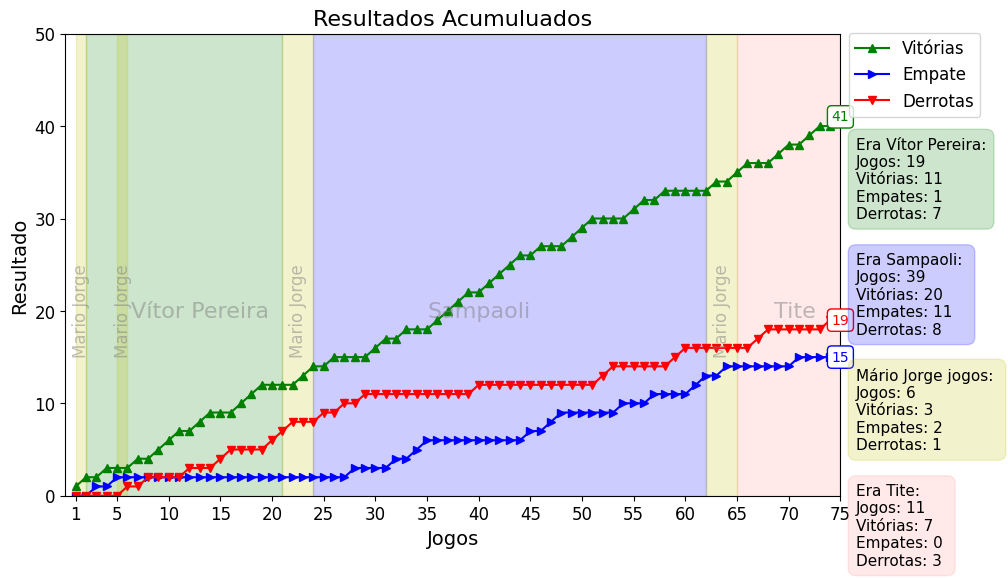

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.title('Resultados Acumuluados', fontsize=16)

plt.plot(stats['jogos_cumulativos'], stats['Vitórias_cumulativas'], label='Vitórias', color='green', marker="^")
plt.plot(stats['jogos_cumulativos'], stats['Empates_cumulativas'], label='Empate', color='blue', marker=">")
plt.plot(stats['jogos_cumulativos'], stats['Derrotas_cumulativas'], label='Derrotas', color='red', marker="v")

plt.axvspan(min(VP_time['jogos_cumulativos']), max(VP_time['jogos_cumulativos']),
           facecolor='g', edgecolor='g', alpha=.2)

plt.axvspan(min(Sampaoli_time['jogos_cumulativos']), max(Sampaoli_time['jogos_cumulativos']),
           facecolor='b', edgecolor='b', alpha=.2)

for i in [0, 1]:#range(len(MJ_games.jogos_cumulativos)):
    plt.axvspan(MJ_games['jogos_cumulativos'].to_list()[i], MJ_games['jogos_cumulativos'].to_list()[i] + 1,
               facecolor='y', edgecolor='y', alpha=.2)
    
for i in [2, 4]:
    plt.axvspan(MJ_games['jogos_cumulativos'].to_list()[i] - 1, MJ_games['jogos_cumulativos'].to_list()[i] + 2, 
                facecolor='y', edgecolor='y', alpha=.2)
    
    
plt.axvspan(min(Tite_time['jogos_cumulativos']), max(Tite_time['jogos_cumulativos']),
           facecolor='#ff9191', edgecolor='#ff9191', alpha=.2)


plt.ylim(0, 50)
plt.xlim(0, 75)

plt.ylabel('Resultado', fontsize=14)
plt.yticks(fontsize=12)

plt.xlabel('Jogos', fontsize=14)
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75], fontsize=12)

plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=14)

plt.text(13,20, 'Vítor Pereira', fontsize=16, color='gray', alpha=0.5,
        ha='center', va='center')

plt.text(40,20, 'Sampaoli', fontsize=16, color='gray', alpha=0.5,
        ha='center', va='center')

for i, j in [[1.55, 20], [5.55, 20], [22.55, 20], [63.55, 20]]:
    plt.text(i, j, 'Mario Jorge', fontsize=12, color='gray', alpha=0.5,
        ha='center', va='center', rotation=90)
    
    
plt.text(70.55,20, 'Tite', fontsize=16, color='gray', alpha=0.5,
        ha='center', va='center')  

box_offset = 5  # Adjust this value to control the vertical offset of the boxes
plt.text(len(stats['Vitórias_cumulativas']), stats['Vitórias_cumulativas'].iloc[-1], f"{stats['Vitórias_cumulativas'].iloc[-1]}",
         ha='center', va='center', color='green', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'),
         fontsize=10)

plt.text(len(stats['Empates_cumulativas']), stats['Empates_cumulativas'].iloc[-1], f"{stats['Empates_cumulativas'].iloc[-1]}",
         ha='center', va='center', color='blue', bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3'),
         fontsize=10)

plt.text(len(stats['Derrotas_cumulativas']), stats['Derrotas_cumulativas'].iloc[-1], f"{stats['Derrotas_cumulativas'].iloc[-1]}",
         ha='center', va='center', color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'),
         fontsize=10)


MJ_stats = '''Mário Jorge jogos: 
Jogos: {0}
Vitórias: {1} 
Empates: {2} 
Derrotas: {3}'''.format(MJ_games.shape[0],
                        MJ_games['resultado'].value_counts()[0], 
                        MJ_games['resultado'].value_counts()[1], 
                        MJ_games['resultado'].value_counts()[2])

VP_stats = '''Era Vítor Pereira:
Jogos: {0}
Vitórias: {1} 
Empates: {2} 
Derrotas: {3}'''.format(VP_time.shape[0],
                        VP_time['resultado'].value_counts()[0], 
                        VP_time['resultado'].value_counts()[2], 
                        VP_time['resultado'].value_counts()[1])


Sampaoli_stats = '''Era Sampaoli: 
Jogos: {0}
Vitórias: {1} 
Empates: {2} 
Derrotas: {3}'''.format(Sampaoli_time.shape[0],
                        Sampaoli_time['resultado'].value_counts()[0], 
                        Sampaoli_time['resultado'].value_counts()[1], 
                        Sampaoli_time['resultado'].value_counts()[2])


Tite_stats = '''Era Tite: 
Jogos: {0}
Vitórias: {1} 
Empates: {2} 
Derrotas: {3}'''.format(Tite_time.shape[0],
                        Tite_time['resultado'].value_counts()[0], 
                        0, 
                        Tite_time['resultado'].value_counts()[1])


plt.text(1.02, 0.6, VP_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='g', edgecolor='g', alpha=.2, boxstyle='round, pad=0.5'))

plt.text(1.02, 0.35, Sampaoli_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='b', edgecolor='b', alpha=.2, boxstyle='round, pad=0.5'))

plt.text(1.02, 0.10, MJ_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='y', edgecolor='y', alpha=.2, boxstyle='round, pad=0.5'))

plt.text(1.02, -0.15, Tite_stats, transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(facecolor='#ff9191', edgecolor='#ff9191', alpha=.2, boxstyle='round, pad=0.5'))

plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper left', fontsize=12)

#plt.figtext(.92, 0.28, '@williamjouse', ha='right', va='top', alpha=0.5, fontsize=10, rotation=90)


plt.savefig('figures/figure8.png', dpi = 300, bbox_inches='tight')

plt.show()

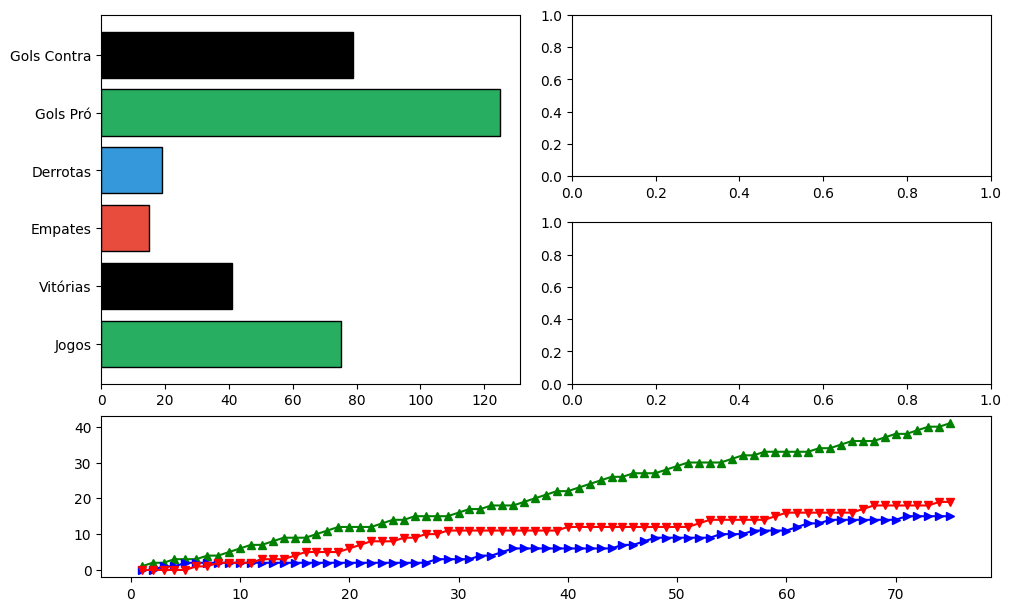

In [33]:
fig = plt.figure(constrained_layout=True, figsize=(10,6))
mosaic = fig.subplot_mosaic('''
                     AB
                     AC
                     DD''')

mosaic['A'].barh(labels, values, color=['#27AE60', 'black', '#E74C3C', '#3498DB'], edgecolor='black')



mosaic['D'].plot(stats['jogos_cumulativos'], stats['Vitórias_cumulativas'], label='Vitórias', color='green', marker="^")
mosaic['D'].plot(stats['jogos_cumulativos'], stats['Empates_cumulativas'], label='Empate', color='blue', marker=">")
mosaic['D'].plot(stats['jogos_cumulativos'], stats['Derrotas_cumulativas'], label='Derrotas', color='red', marker="v")